raw_text:
Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !

processed_text:
go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !
source:
[['go', '.'], ['hi', '.'], ['run', '!'], ['run', '!'], ['who', '?'], ['wow', '!']]
target:
[['va', '!'], ['salut', '!'], ['cours', '!'], ['courez', '!'], ['qui', '?'], ['ça', 'alors', '!']]
X: tensor([[  6, 146,   8,   4,   3,   1,   1,   1],
        [  6,  18, 153,   4,   3,   1,   1,   1]], dtype=torch.int32)
X的有效长度: tensor([8, 8])
Y: tensor([[  6,  46, 157,   4,   3,   1,   1,   1],
        [  6,   7,  60,   4,   3,   1,   1,   1]], dtype=torch.int32)
Y的有效长度: tensor([8, 8])


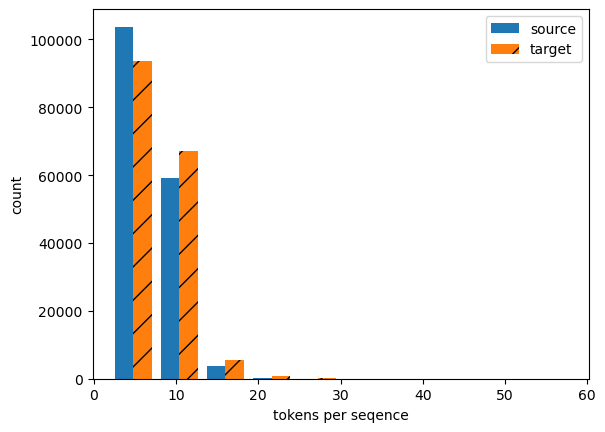

In [1]:
import torch, os, utils
import matplotlib.pyplot as plt
from utils import DATA_URL
DATA_HUB = {}
DATA_HUB['fra-eng'] = (DATA_URL+'fra-eng.zip', '94646ad1522d915e7b0f9296181140edcf86a4f5')

# 一、下载数据集
def read_dataset_nmt():
    """
    下载并读取一个由Tatoeba项目的双语句子对组成的"英-法"数据集\n
    数据集中的每一行都是制表符分隔的文本序列对，序列对由英文文本序列和翻译后的法语文本序列组成。\n
    每个文本序列可以是一个句子，也可以是包含多个句子的一个段落\n
    在这个将英语翻译成法语的机器翻译问题中，英语是源语言, 法语是目标语言。
    """
    data_dir = utils.download_extract(DATA_HUB, name='fra-eng', save_folder_name='french_to_english')
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding='utf-8') as f:
        return f.read()

# 二、数据集预处理
def dataset_preprocess_nmt(text):
    """预处理英语-法语数据集"""
    def no_space(char, prev_char) -> bool:
        """
        检查char(必须属于, . ! ?中的一个)前面的字符是不是空格\n
        如果char在set里且prev_char不是空格, 说明prev_char属于一个句尾的单词, 且和句尾标点间无空格, 返回True
        """
        return char in set(',.!?') and prev_char != ' '
    
    # 用空格替换不间断空格 用小写字母替换大写字母(其中\u202f和\xa0分别是Unicode中的窄不间断空格和不间断空格)
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间加入空格
    out = [' ' + char if i>0 and no_space(char, text[i-1]) else char for i, char in enumerate(text)]
    return ''.join(out) # 连成句子 separator.join()方法用separator将可迭代对象中的元素连接成一个字符串

def tokenize_nmt(text, num_examples=None):
    """
    对text的前num_examples个文本序列词元化\n
    其中每个词元要么是一个词,要么是一个标点符号。\n
    返回:\n
        两个词元列表:source和target\n
        source[i]是源语言第i个文本序列的词元列表,\n
        target[i]是目标语言第i个文本序列的词元列表。
    """
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i>num_examples:
            break
        pair = line.split('\t') # 数据集的词对是用制表符隔开的
        if len(pair) == 2:
            source.append(pair[0].split(' '))
            target.append(pair[1].split(' '))
    return source, target

def show_list_len_pair_histogram(data_lists, legends, xlabel, ylabel):
    """绘制一个直方图,显示target和source中的序列中的词元数量"""
    x = []
    for data_list in data_lists:
        x.append([len(token) for token in data_list])
    _, _, patches = plt.hist(x, label=legends)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

"""
由于机器翻译数据集由语言对组成，因此可以分别为源语言和目标语言构建两个词表。
使用单词级词元化时，词表大小将明显大于使用字符级词元化时的词表大小。
为了缓解这一问题，将出现次数少于2次的低频率词元视为相同的未知("<unk>")词元。
除此之外，指定额外的特定词元，例如在小批量时用于将序列填充到相同长度的填充词元("<pad>")，以及序列的开始词元("<bos>")和结束词元("<eos>")。
这些特殊词元在自然语言处理任务中比较常用。
"""

def truncate_pad(line, num_steps, padding_token):
    """
    通过截断(truncation)和 填充(padding)方式实现一次只处理一个小批量的文本序列。\n
    假设同一个小批量中的每个序列都应该具有相同的长度num_steps，那么如果文本序列的词元数目少于num_steps时，\n
    我们将继续在其末尾添加特定的“<pad>”词元，直到其长度达到num_steps；\n
    反之,我们将截断文本序列时，只取其前num_steps 个词元，并且丢弃剩余的词元。\n
    这样，每个文本序列将具有相同的长度，以便以相同形状的小批量进行加载。\n
    参数:\n
        line : 一个文本序列\n
        num_steps : 同一个小批量中所有文本序列的最大长度。\n
        padding_token : 用于填充的特殊词元。\n
    返回:\n
        list: 截断或填充后的文本序列。\n
    """
    if len(line) > num_steps:
        return line[:num_steps] # 截断
    else:
        return line + [padding_token] * (num_steps - len(line)) # 填充

def seq_to_batch_nmt(lines, vocab, num_steps):
    """
    将文本序列转换为小批量。\n
    参数:\n
        lines: 按行划分的文本序列\n
        vocab: 词表\n
        num_steps: 同一个小批量中所有文本序列的最大长度。\n
    返回:\n
        array : 每个文本序列的词元索引\n
        valid_len : 每个文本序列的有效长度\n
    """
    lines = [vocab[line] for line in lines] # 每一行转换为词元的索引(一行有多个单词,一个单词是一个索引,组成一个列表), lines是个二维列表
    lines = [line + [vocab['<eos>']] for line in lines] # 在每条文本序列后添加一个特殊的<eos>词元表明序列结束
    array = torch.tensor([truncate_pad(line, num_steps, vocab['<pad>']) for line in lines]) # 填充或截断后的词元索引
    valid_len = (array!=vocab['pad']).type(torch.int32).sum(axis=1) # 一个列表, 表示每条文本序列中有效单词数
    return  array, valid_len

def load_data_nmt(batch_size, num_steps, num_examples=600):
    """
    返回翻译数据集的迭代器和词表
    """
    text = dataset_preprocess_nmt(read_dataset_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = utils.Vocabulary(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = utils.Vocabulary(target, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = seq_to_batch_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = seq_to_batch_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = utils.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

if __name__== '__main__':
    raw_text = read_dataset_nmt()
    print(f"raw_text:\n{raw_text[:75]}")
    text = dataset_preprocess_nmt(raw_text)
    print(f"processed_text:\n{text[:80]}")
    source, target = tokenize_nmt(text)
    print(f"source:\n{source[:6]}\ntarget:\n{target[:6]}")
    show_list_len_pair_histogram([source,target], ['source', 'target'], 'tokens per seqence', 'count') # 结果:大多数文本序列的词元数量少于20个。
    src_vocab = utils.Vocabulary(source, min_freq=2, reserved_tokens=['<bos>', '<eos>', '<pad>']) # 源语言的词表 len=10012
    train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
    for X, X_valid_len, Y, Y_valid_len in train_iter:
        print('X:', X.type(torch.int32))
        print('X的有效长度:', X_valid_len)
        print('Y:', Y.type(torch.int32))
        print('Y的有效长度:', Y_valid_len)
        break